The goal of this notebook is to see what happens when we preprocess pulses in the frequency domain, but then later convert back to time domain.

In [1]:
import os
import pickle
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal.windows import tukey
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [2]:
# Loading ex-vivo data
path_to_data = "Data\\Ex-Vivo\\"
files = os.listdir(path_to_data)

# Removing readme
files.remove("READ_ME.txt")

data = []

for file in files:
    with open(path_to_data + file, 'rb') as f:
        data.append(pickle.load(f))

# sorting data based on date

for d in data:
    timestamp = d['time']
    d['date'] = datetime.fromisoformat(timestamp)

data = sorted(data, key=lambda x: x['date'])

x = data[4]['scan'][0]['forward_scan']['time']
y = data[4]['scan'][0]['forward_scan']['signal']

# Fixing labeling errors

data[51]['samplematrix'] = 'sample 7 PBS'
data[51]['conc'] = 0.0

data[52]['samplematrix'] = 'sample 8 g/PBS'
data[52]['conc'] = 2.5

data[53]['samplematrix'] = 'sample 6 g/PBS'
data[53]['conc'] = 2.5


# Fixing issue with sample ids due to multiple days

for d in data:
    d['samplematrix_fixed'] = d['samplematrix']

for d in data[37:]:
    values = d['samplematrix'].split()
    if len(values) > 1:
        id = int(values[1])
        new_id = id+18
        new_samplematrix = values[0] + " " + str(new_id) + " " + values[2]
        d['samplematrix_fixed'] = new_samplematrix


# Removing air and NC as these are irrelevant for our purpose
data = [d for d in data if not d['samplematrix_fixed'] == 'air']

ids_to_remove = []

for d in data:
    values = d['samplematrix_fixed'].split()
    if values[2] == 'NC':
        ids_to_remove.append(values[1])

data = [d for d in data if not d['samplematrix_fixed'].split()[1] in ids_to_remove]

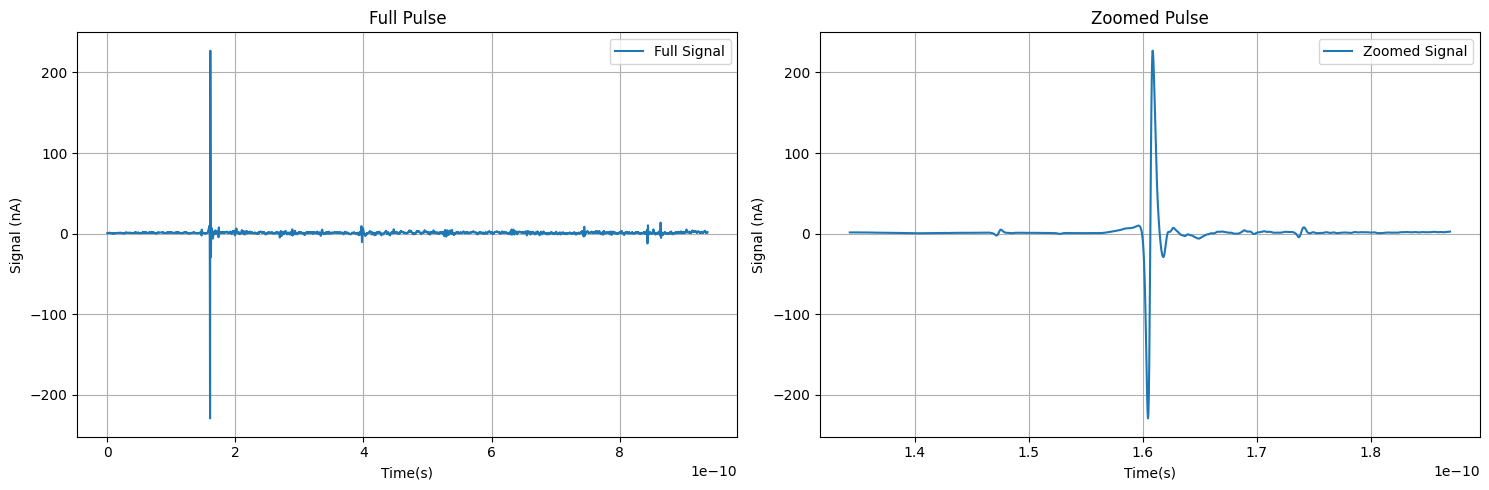

In [3]:
min_index = np.argmin(y)
max_index = np.argmax(y)
middle_index = math.floor((min_index + max_index) / 2)
zoom_start = middle_index - 700
zoom_end = middle_index + 700

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y, label='Full Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Full Pulse")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x[zoom_start:zoom_end], y[zoom_start:zoom_end], label='Zoomed Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Zoomed Pulse")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [4]:
# just taking first forward scan in each file
for d in data:
    d['avg_signal'] = d['scan'][0]['forward_scan']['signal']
    d['avg_time'] = d['scan'][0]['forward_scan']['time']

    d['avg_ref_signal'] = d['ref'][0]['forward_scan']['signal']
    d['avg_ref_time'] = d['ref'][0]['forward_scan']['time']

In [5]:
# Applying Tukey window to all signals

window_size = 325
alpha = 0.80

for d in data:

    # Applying Tukey window to avg signal
    y = d['avg_signal']
    min_index = np.argmin(y)
    max_index = np.argmax(y)
    middle_index = math.floor((min_index+max_index)/2)
    window_start = middle_index - window_size
    window_end = middle_index + window_size
    window = tukey(window_end-window_start, alpha = alpha)
    windowed_signal = y[window_start: window_end] * window
    y = np.zeros(len(y), dtype=float)
    y[window_start: window_end] = windowed_signal

    d['avg_tukey'] = y
    
    # Applying Tukey window to avg ref signal
    y = d['avg_ref_signal']
    min_index = np.argmin(y)
    max_index = np.argmax(y)
    middle_index = math.floor((min_index+max_index)/2)
    window_start = middle_index - window_size
    window_end = middle_index + window_size
    window = tukey(window_end-window_start, alpha = alpha)
    windowed_signal = y[window_start: window_end] * window
    y = np.zeros(len(y), dtype=float)
    y[window_start: window_end] = windowed_signal

    d['avg_ref_tukey'] = y

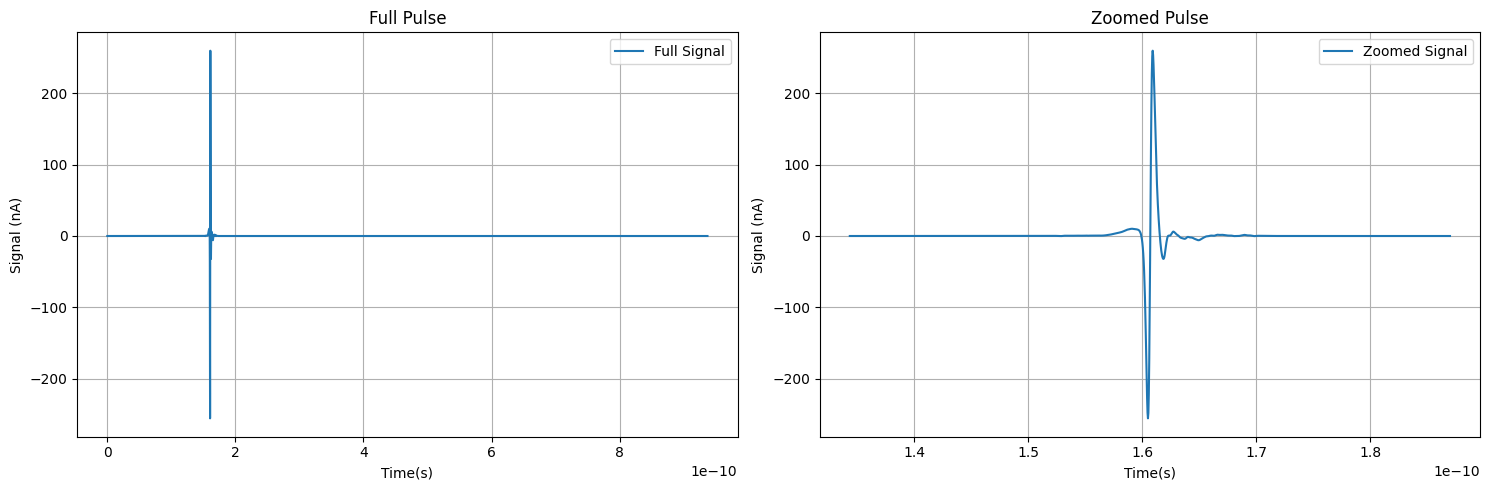

In [6]:
# Plotting effect of tukey window
x = data[4]['avg_time']
y = data[4]['avg_tukey']

min_index = np.argmin(y)
max_index = np.argmax(y)
middle_index = math.floor((min_index + max_index) / 2)
zoom_start = middle_index - 700
zoom_end = middle_index + 700

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y, label='Full Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Full Pulse")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x[zoom_start:zoom_end], y[zoom_start:zoom_end], label='Zoomed Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Zoomed Pulse")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [68]:
def double_gaussian_filter(t, t0, frequencies, spectrum, fc1, fc2):
   
        """
        Compute and apply the double Gaussian filter.
 
        Parameters:
        t (numpy array): Time domain array
        t0 (float): Time of max of the pulse
        frequencies (numpy array): Frequency axis from data
        spectrum (numpy array): Complex spectrum from data
        fc1 (float): Frequency cut-off for the first Gaussian
        fc2 (float): Frequency cut-off for the second Gaussian
 
        Returns:
        frequencies (numpy array): Frequency axis of data
        filtered_spectrum (numpy array): Complex frequency spectrum
        """
 
        # Define Gaussian function in time domain
        def gaussian_time(t, sigma):
            phi_t = np.exp(-(t-t0)**2 / (2 * sigma**2))
            phi_t = phi_t / phi_t.sum()
            return phi_t
 
        # Calculate the standard deviations for the desired cutoff frequencies
        sigma2 = 1 / (2 * np.pi * fc1)
        sigma1 = 1 / (2 * np.pi * fc2)
 
        # Define Difference of Gaussians in time domain
        G1 = gaussian_time(t, sigma1)
        G2 = gaussian_time(t, sigma2)
        DoG_time = G1 - G2
 
        # Frequency response of filter
        DoG_freq = np.fft.rfftfreq(len(DoG_time), d=t[1] - t[0])
        DoG_fft = np.fft.rfft(DoG_time)
 
        # Apply the filter in the frequency domain
        DoG_fft_interp = np.interp(frequencies, DoG_freq, DoG_fft)  # Interpolate to match the frequency bins of the FFT
        filtered_spectrum = spectrum * DoG_fft_interp
 
        return frequencies, filtered_spectrum

# Applying FFT to all signals


# TODO: convert to fft (no absolute value) -> divide sample with reference -> optional frequency filter -> inverse fft
# then continue subtracting bare from rteated in time domain

# TODO: Check ECG data for GAN implementation

for d in data:

    # Applying FFT to avg signal
    x = d['avg_time']
    y = d['avg_tukey']

    fft_result = np.fft.rfft(y)

    # The result of FFT is a list of complex numbers that represent the frequency spectrum of the signal
    # These values themselves do not directly tell us the magnitude of the frequency or the phase of the frequency.

    # To get the amplitude of a frequency, we need to calculate the modulus of the complex number.
    # Modulus means the absolute value, which for real numbers is the number itself without any signs.
    # However, for complex numbers, the modulus is the square root of the sum of the squares of the real and imaginary parts.

    # The phase of a frequency is the angle of the complex number in the complex plane.
    # We can calculate the phase of a frequency by taking the arctangent of the imaginary part divided by the real part.

    amplitudes = np.abs(fft_result)
    amplitudes = amplitudes / len(y)

    frequencies = np.fft.rfftfreq(len(y))
    frequencies = frequencies * (10**(-12)) # converting to THz

    d['avg_amplitudes'] = amplitudes
    d['avg_frequencies'] = frequencies
    d['fft_result'] = fft_result


    max_index = np.argmax(d['avg_signal'])
    d['fft_filter'] = double_gaussian_filter(d['avg_signal'], max_index, frequencies, fft_result, 1, 2)


    # Applying FFT to avg ref signal
    x = d['avg_ref_time']
    y = d['avg_ref_tukey']

    fft_result = np.fft.rfft(y)

    amplitudes = np.abs(fft_result)
    amplitudes = amplitudes / len(y)

    frequencies = np.fft.rfftfreq(len(y))
    frequencies = frequencies * (10**(-12)) # converting to THz
    d['avg_ref_amplitudes'] = amplitudes
    d['avg_ref_frequencies'] = frequencies
    d['fft_ref_result'] = fft_result

    max_index = np.argmax(d['avg_ref_signal'])
    d['fft_ref_filter'] = double_gaussian_filter(d['avg_ref_signal'], max_index, frequencies, fft_result, 1, 2)

C:\Users\asama\AppData\Local\Temp\ipykernel_21168\3411073404.py:22: RuntimeWarning: invalid value encountered in divide
  phi_t = phi_t / phi_t.sum()


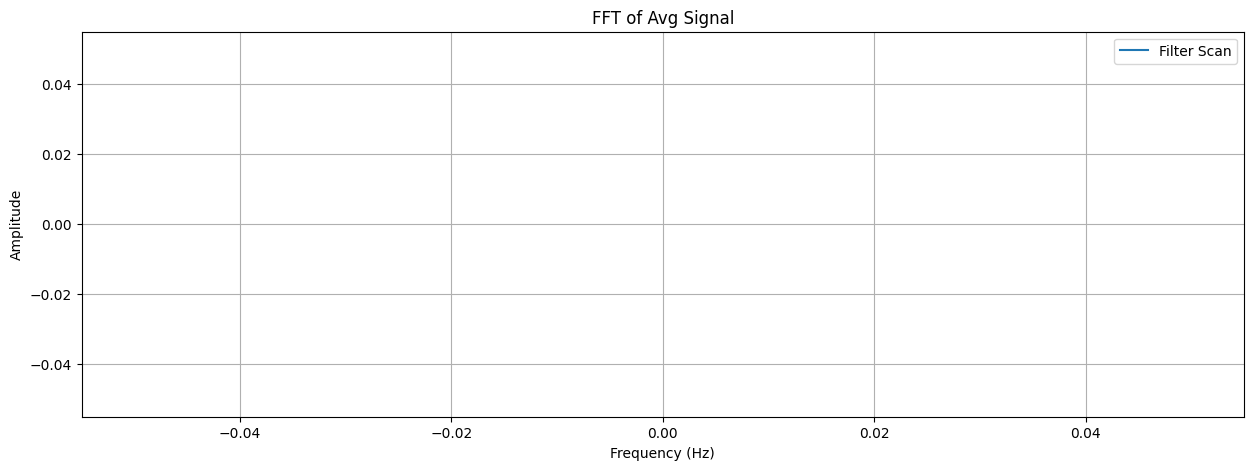

In [70]:
# simple plot of fft
xf_scan = data[1]['avg_frequencies']
yf_scan = data[1]['avg_amplitudes']

xf_ref = data[1]['avg_ref_frequencies']
yf_ref = data[1]['avg_ref_amplitudes']

plt.figure(figsize=(15, 5))
#plt.plot(xf_scan, yf_scan, label='Scan')
#plt.plot(xf_ref, yf_ref, label='Ref')
plt.plot(data[1]['fft_filter'][0], np.abs(data[1]['fft_filter'][1]), label='Filter Scan')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT of Avg Signal")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# Normalizing FFT results using reference signal
for d in data:
    d['fft_result_normalized'] = d['fft_result'] / d['fft_ref_result']

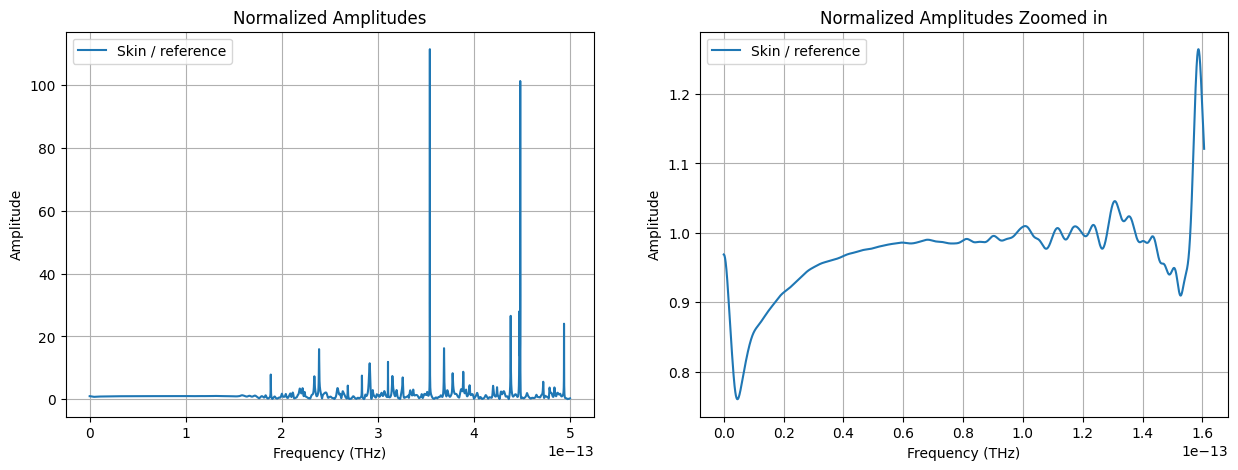

In [21]:
# plotting normalized fft

fft_to_plot = data[1]['fft_result_normalized']
raw_signal = data[1]['avg_tukey']

amplitudes = np.abs(fft_to_plot)
frequencies = np.fft.rfftfreq(len(raw_signal))
frequencies = frequencies * (10**(-12)) # converting to THz

x = frequencies
y = amplitudes

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y, label='Skin / reference')
plt.xlabel("Frequency (THz)")
plt.ylabel("Amplitude")
plt.title("Normalized Amplitudes")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x[0:4000], y[0:4000], label='Skin / reference')
plt.xlabel("Frequency (THz)")
plt.ylabel("Amplitude")
plt.title("Normalized Amplitudes Zoomed in")
plt.legend()
plt.grid(True)

plt.show()

In [22]:
print(data[1]['samplematrix_fixed'])
print(data[7]['samplematrix_fixed'])

sample 2 bare
sample 2 PBS


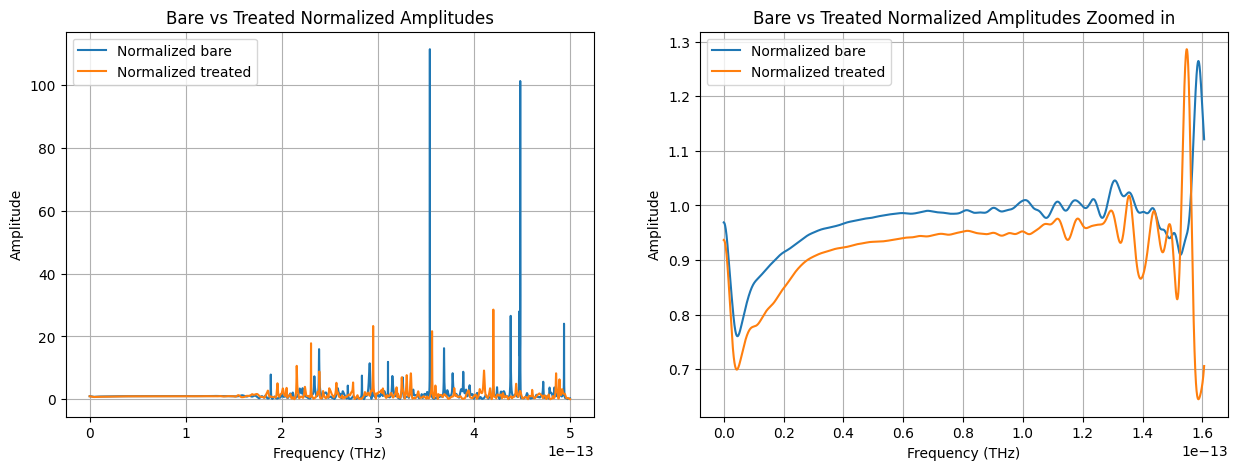

In [23]:
# Plotting the normalized bare pulse vs its corresponding normalized treated pulse

fft_bare = data[1]['fft_result_normalized']
fft_treated = data[7]['fft_result_normalized']

signal_bare = data[1]['avg_tukey']
signal_treated = data[7]['avg_tukey']

amplitudes_bare = np.abs(fft_bare)
frequencies_bare = np.fft.rfftfreq(len(signal_bare))
frequencies_bare = frequencies_bare * (10**(-12)) # converting to THz

amplitudes_treated = np.abs(fft_treated)
frequencies_treated = np.fft.rfftfreq(len(signal_treated))
frequencies_treated = frequencies_treated * (10**(-12)) # converting to THz

xf_bare = frequencies_bare
yf_bare = amplitudes_bare

xf_treated = frequencies_treated
yf_treated = amplitudes_treated

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(xf_bare, yf_bare, label='Normalized bare')
plt.plot(xf_treated, yf_treated, label='Normalized treated')
plt.xlabel("Frequency (THz)")
plt.ylabel("Amplitude")
plt.title("Bare vs Treated Normalized Amplitudes")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(xf_bare[0:4000], yf_bare[0:4000], label='Normalized bare')
plt.plot(xf_treated[0:4000], yf_treated[0:4000], label='Normalized treated')
plt.xlabel("Frequency (THz)")
plt.ylabel("Amplitude")
plt.title("Bare vs Treated Normalized Amplitudes Zoomed in")
plt.legend()
plt.grid(True)

plt.show()

In [25]:
# Creating sample ID as separate field in data dict
for d in data:
    d['sample_id'] = d['samplematrix_fixed'].split()[1]

In [27]:
# Normalizing using bare signal
treated_data = [d for d in data if not 'bare' in d['samplematrix_fixed']]
bare_data = [d for d in data if 'bare' in d['samplematrix_fixed']]
for d in treated_data:
    corresponding_bare = [b for b in bare_data if b['sample_id'] == d['sample_id']][0]
    d['fft_result_normalized_final'] = d['fft_result_normalized'] / corresponding_bare['fft_result_normalized']

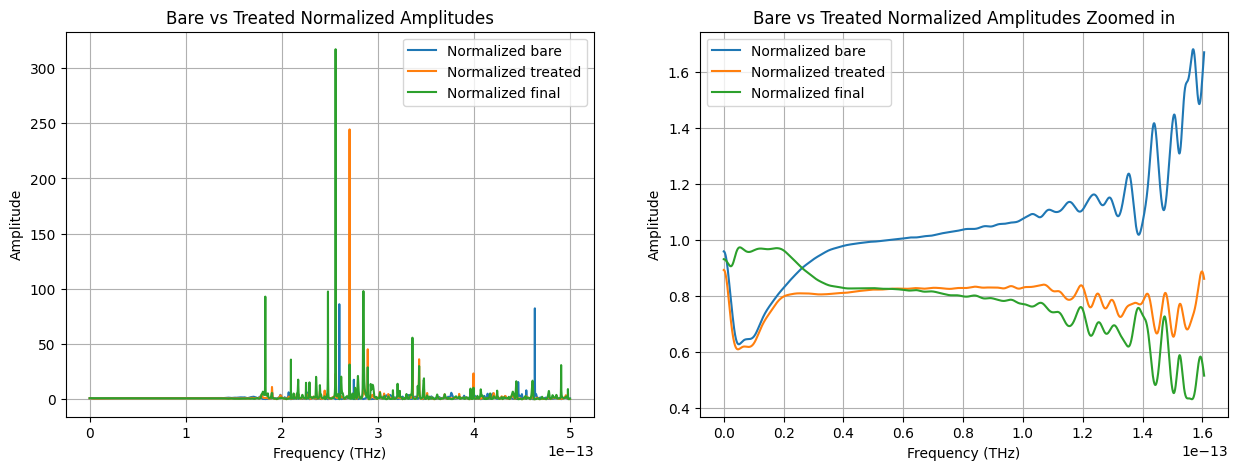

In [32]:
# plotting final normalized fft

i = 0

fft_final = treated_data[i]['fft_result_normalized_final']
fft_bare = bare_data[i]['fft_result_normalized']
fft_treated = treated_data[i]['fft_result_normalized']

signal_bare = bare_data[i]['avg_tukey']
signal_treated = treated_data[i]['avg_tukey']

amplitudes_final = np.abs(fft_final)
amplitudes_bare = np.abs(fft_bare)
amplitudes_treated = np.abs(fft_treated)

frequencies_final = np.fft.rfftfreq(len(signal_bare))
frequencies_final = frequencies_final * (10**(-12)) # converting to THz

xf_final = frequencies_final
yf_final = amplitudes_final

xf_bare = frequencies_final
yf_bare = amplitudes_bare

xf_treated = frequencies_final
yf_treated = amplitudes_treated

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(xf_bare, yf_bare, label='Normalized bare')
plt.plot(xf_treated, yf_treated, label='Normalized treated')
plt.plot(xf_final, yf_final, label='Normalized final')
plt.xlabel("Frequency (THz)")
plt.ylabel("Amplitude")
plt.title("Bare vs Treated Normalized Amplitudes")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(xf_bare[0:4000], yf_bare[0:4000], label='Normalized bare')
plt.plot(xf_treated[0:4000], yf_treated[0:4000], label='Normalized treated')
plt.plot(xf_final[0:4000], yf_final[0:4000], label='Normalized final')
plt.xlabel("Frequency (THz)")
plt.ylabel("Amplitude")
plt.title("Bare vs Treated Normalized Amplitudes Zoomed in")
plt.legend()
plt.grid(True)

plt.show()

In [57]:
# converting back to time domain
for t in treated_data:
    fft_result = t['fft_result_normalized_final']
    signal = np.fft.irfft(fft_result)
    t['final_signal'] = signal

for t in treated_data:
    fft_result = t['fft_result_normalized']
    signal = np.fft.irfft(fft_result)
    t['final_signal'] = signal

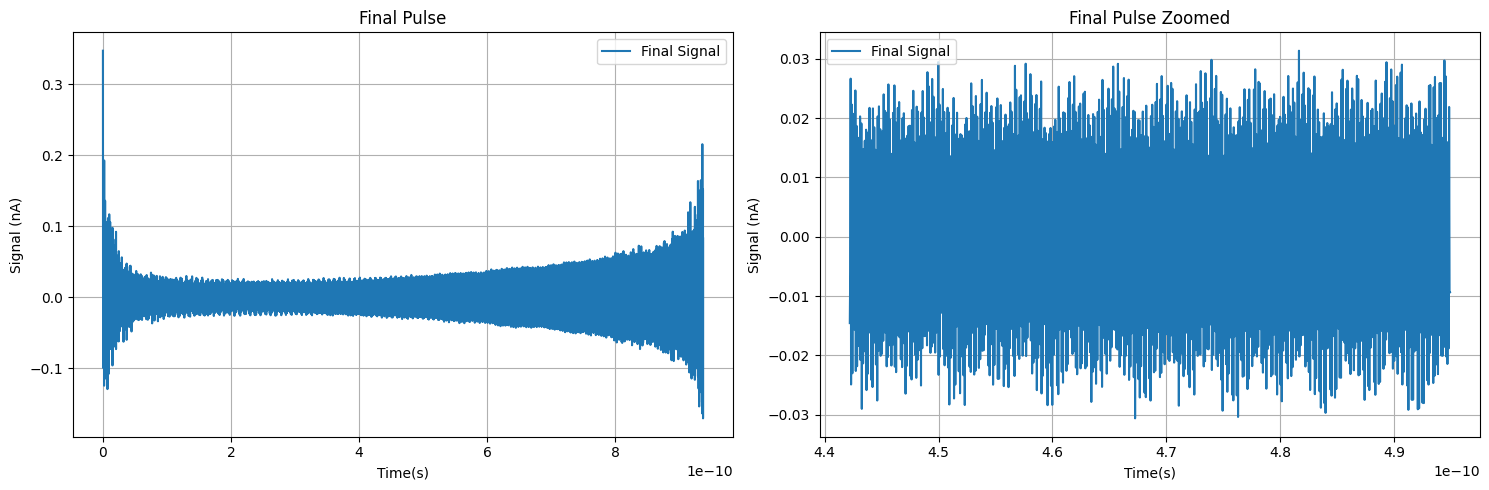

In [58]:
# plotting final signal

i = 3

x = treated_data[i]['avg_time']
y = treated_data[i]['final_signal']

min_index = np.argmin(y)
max_index = np.argmax(y)
middle_index = math.floor((min_index + max_index) / 2)
zoom_start = middle_index - 700
zoom_end = middle_index + 700

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y, label='Final Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Final Pulse")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x[zoom_start:zoom_end], y[zoom_start:zoom_end], label='Final Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Final Pulse Zoomed")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [47]:
# Experiment: What if we only inverse the first 4000 frequencies, before it becomes too unstable?

# question: how to inverse fft only a part of the frequencies? Do we set the rest to zero? Or can we just take the first 4000 frequencies?

# answer: We will try both


for t in treated_data:
    fft_result = t['fft_result_normalized_final'].copy()
    fft_result_cut = fft_result[0:4000]
    fft_result[4000:] = 0
    fft_result_0 = fft_result

    t['final_signal_cut'] = np.fft.irfft(fft_result_cut)
    t['final_signal_0'] = np.fft.irfft(fft_result_0)

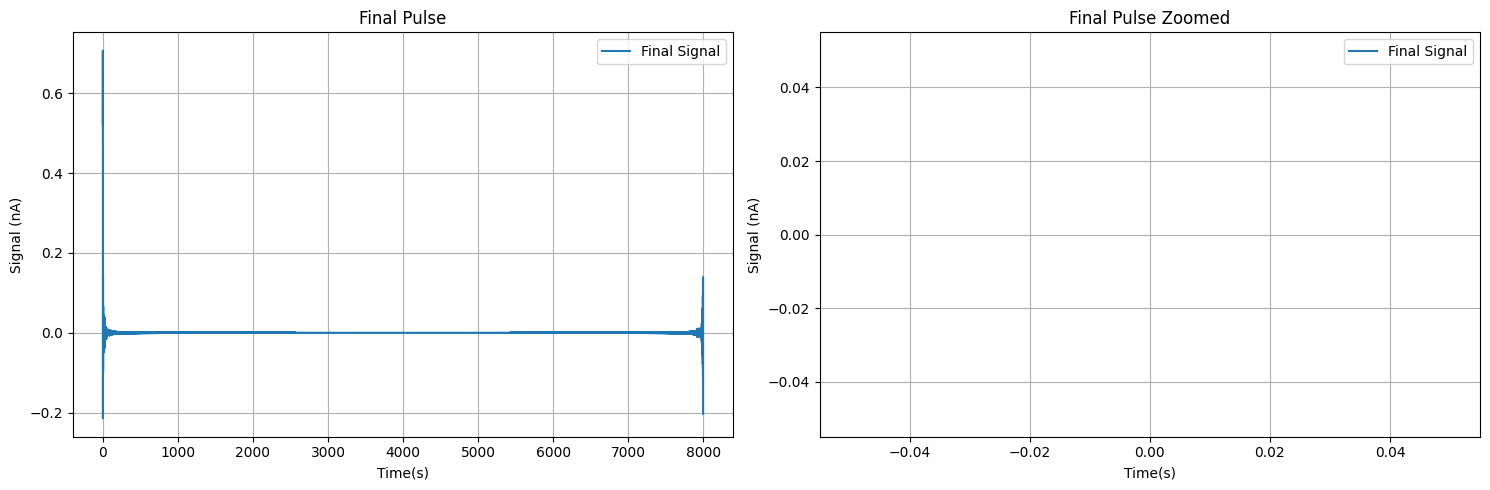

In [53]:
# plotting final signal where we only inverse the first 4000 frequencies

i = 3

x = np.arange(0, len(treated_data[i]['final_signal_cut']), 1)
y = treated_data[i]['final_signal_cut']

min_index = np.argmin(y)
max_index = np.argmax(y)
middle_index = math.floor((min_index + max_index) / 2)
zoom_start = middle_index - 300
zoom_end = middle_index + 300

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y, label='Final Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Final Pulse")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x[zoom_start:zoom_end], y[zoom_start:zoom_end], label='Final Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Final Pulse Zoomed")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

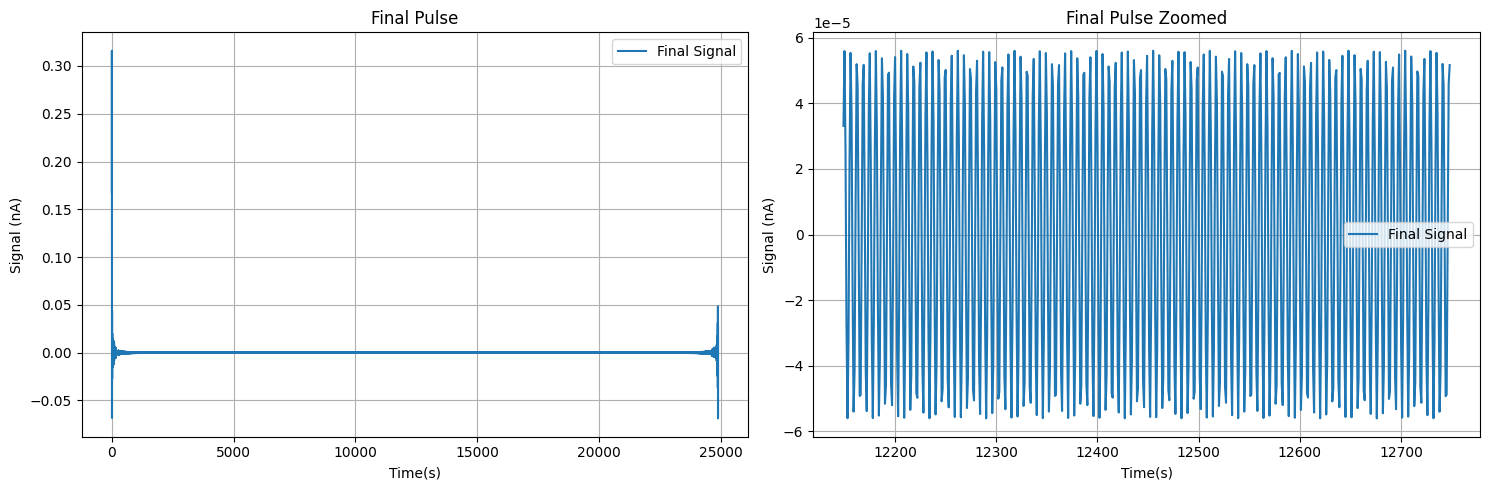

In [55]:
# plotting final signal where we only inverse all frequencies but set to zero after 4000

i = 3

x = np.arange(0, len(treated_data[i]['final_signal_0']), 1)
y = treated_data[i]['final_signal_0']

min_index = np.argmin(y)
max_index = np.argmax(y)
middle_index = math.floor((min_index + max_index) / 2)
zoom_start = middle_index - 300
zoom_end = middle_index + 300

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y, label='Final Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Final Pulse")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x[zoom_start:zoom_end], y[zoom_start:zoom_end], label='Final Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Final Pulse Zoomed")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()